<a href="https://colab.research.google.com/github/Rashimanish/-Insurance-Cross-Selling/blob/main/Selected_Model/LIGHTGM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc, confusion_matrix
from sklearn.utils import resample
import lightgbm as lgb
import joblib

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [ ]:
# Mount Google Drive
drive.mount('/content/drive')

# File path
file_path = '/content/drive/My Drive/INSURANCE/train.csv'
# Read dataset
df = pd.read_csv(file_path)


Mounted at /content/drive


In [ ]:
df.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,0,Male,21,1,35.0,0,1-2 Year,Yes,65101.0,124.0,187,0
1,1,Male,43,1,28.0,0,> 2 Years,Yes,58911.0,26.0,288,1
2,2,Female,25,1,14.0,1,< 1 Year,No,38043.0,152.0,254,0
3,3,Female,35,1,1.0,0,1-2 Year,Yes,2630.0,156.0,76,0
4,4,Female,36,1,15.0,1,1-2 Year,No,31951.0,152.0,294,0


## **Outlier Inspection & Treatment**

In [ ]:
# Outlier treatment function
def outlier_treatment(df):
    Q1 = df['Annual_Premium'].quantile(0.25)
    Q3 = df['Annual_Premium'].quantile(0.75)
    IQR = Q3 - Q1

    Lower_Whisker = Q1 - 1.5 * IQR
    Upper_Whisker = Q3 + 1.5 * IQR

    df['Annual_Premium'] = np.where(df['Annual_Premium'] > Upper_Whisker, Upper_Whisker,
                                    np.where(df['Annual_Premium'] < Lower_Whisker, Lower_Whisker,
                                             df['Annual_Premium']))
    return df


## **Feature Engineering**

In [ ]:
# Feature engineering function
def feature_engineering(df):

  #categorical --> numerical
    df["Vehicle_Age"] = df["Vehicle_Age"].astype('category').cat.rename_categories({
        "1-2 Year": 1,
        "< 1 Year": 0,
        "> 2 Years": 2
    }).astype('int8')

    #Binary Encoding
    df['Gender'] = (df['Gender'] == 'Male').astype(np.uint8)
    df['Vehicle_Damage'] = (df['Vehicle_Damage'] == 'Yes').astype(np.uint8)

    #data types conversion for memory efficiency
    df['Age'] = df['Age'].astype('int8')
    df['Driving_License'] = df['Driving_License'].astype('int8')
    df['Region_Code'] = df['Region_Code'].astype('int8')
    df['Previously_Insured'] = df['Previously_Insured'].astype('int8')
    df['Annual_Premium'] = df['Annual_Premium'].astype('int32')
    df['Policy_Sales_Channel'] = df['Policy_Sales_Channel'].astype('int16')
    df['Vintage'] = df['Vintage'].astype('int16')

    # Create new features
    df['Annual_Premium_Insurance'] = df['Previously_Insured'].astype(str) + df['Annual_Premium'].astype(str)
    df['Annual_Premium_Insurance'] = pd.factorize(df['Annual_Premium_Insurance'])[0] + 1

    df['Vehicle_Age_Insurance'] = df['Previously_Insured'].astype(str) + df['Vehicle_Age'].astype(str)
    df['Vehicle_Age_Insurance'] = pd.factorize(df['Vehicle_Age_Insurance'])[0] + 1

    return df



In [ ]:
# sampling
def sampling(X, y, seed):
    # Random subsampling
    sample_size = len(y[y == 1])  # minority
    X_random = X.sample(n=sample_size * 2, random_state=seed)
    y_random = y.loc[X_random.index]

    # Separate majority and minority classes
    X_maj = X_random[y_random == 0]
    y_maj = y_random[y_random == 0]
    X_min = X_random[y_random == 1]
    y_min = y_random[y_random == 1]

    X_maj = X_maj.drop_duplicates()
    y_maj = y_maj.loc[X_maj.index]

    # sample size = the minority class
    size = len(y_min)

    # Undersampling
    X_maj_undersampled, y_maj_undersampled = resample(X_maj, y_maj,
                                                       replace=False,
                                                       n_samples=size,
                                                       random_state=seed)

    # Combine undersampled majority class with minority class
    X_combined = pd.concat([X_maj_undersampled, X_min])
    y_combined = pd.concat([y_maj_undersampled, y_min])

    return X_combined, y_combined

In [ ]:
X = df.drop(columns=['id', 'Response'])
y = df['Response']

In [ ]:
X = outlier_treatment(X)

In [ ]:
X.head()

,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage
0,Male,21,1,35.0,0,1-2 Year,Yes,60712.0,124.0,187
1,Male,43,1,28.0,0,> 2 Years,Yes,58911.0,26.0,288
2,Female,25,1,14.0,1,< 1 Year,No,38043.0,152.0,254
3,Female,35,1,1.0,0,1-2 Year,Yes,4016.0,156.0,76
4,Female,36,1,15.0,1,1-2 Year,No,31951.0,152.0,294


In [ ]:
X = feature_engineering(X)

In [ ]:
X.head()

,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Annual_Premium_Insurance,Vehicle_Age_Insurance
0,1,21,1,35,0,1,1,60712,124,187,1,1
1,1,43,1,28,0,2,1,58911,26,288,2,2
2,0,25,1,14,1,0,0,38043,152,254,3,3
3,0,35,1,1,0,1,1,4016,156,76,4,1
4,0,36,1,15,1,1,0,31951,152,294,5,4


In [ ]:
# Perform Sampling
X_combined, y_combined = sampling(X, y, seed=35)

In [ ]:
# Cross-validation
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=35)

In [ ]:
def evaluate_model(model, X, y):
    metrics_list = []
    fpr_list = []
    tpr_list = []
    roc_auc_list = []

    for train_index, test_index in cv.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        model.fit(X_train, y_train)

        y_pred = model.predict(X_test)
        y_pred_proba = model.predict_proba(X_test)[:, 1]

        # Calculate ROC curve
        fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
        # Calculate AUC
        roc_auc = auc(fpr, tpr)

        metrics = {
            'accuracy': accuracy_score(y_test, y_pred),
            'precision': precision_score(y_test, y_pred),
            'recall': recall_score(y_test, y_pred),
            'f1_score': f1_score(y_test, y_pred),
            'roc_auc': roc_auc,
            'conf_matrix': confusion_matrix(y_test, y_pred)
        }
        metrics_list.append(metrics)
        fpr_list.append(fpr)
        tpr_list.append(tpr)
        roc_auc_list.append(roc_auc)

    # Average scalar metrics
    avg_metrics = {
        'accuracy': np.mean([m['accuracy'] for m in metrics_list]),
        'precision': np.mean([m['precision'] for m in metrics_list]),
        'recall': np.mean([m['recall'] for m in metrics_list]),
        'f1_score': np.mean([m['f1_score'] for m in metrics_list]),
        'roc_auc': np.mean(roc_auc_list),
        'conf_matrix': np.sum([m['conf_matrix'] for m in metrics_list], axis=0)
    }

    # Average ROC curve values
    mean_fpr = np.linspace(0, 1, 100)
    mean_tpr = np.mean([np.interp(mean_fpr, fpr, tpr) for fpr, tpr in zip(fpr_list, tpr_list)], axis=0)
    mean_tpr[0] = 0.0  # Ensure the curve starts at (0,0)
    mean_auc = np.mean(roc_auc_list)

    return avg_metrics, mean_fpr, mean_tpr, mean_auc

In [ ]:
def performance_metrics(model_name, metrics):
    metrics_df = pd.DataFrame({
        'Metric': ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'ROC AUC'],
        'Score': [
            metrics['accuracy'],
            metrics['precision'],
            metrics['recall'],
            metrics['f1_score'],
            metrics['roc_auc']
        ]
    })

    print(f"\n{model_name} Model Performance Metrics")
    display(metrics_df)

    # Confusion matrix
    conf_matrix_df = pd.DataFrame(metrics['conf_matrix'],
                                  index=['Actual Negative', 'Actual Positive'],
                                  columns=['Predicted Negative', 'Predicted Positive'])

    print("\nConfusion Matrix:")
    display(conf_matrix_df)

In [ ]:
def plot_roc_curve(fpr, tpr, roc_auc, model_name):
    plt.figure()
    plt.plot(fpr, tpr, lw=2, label=f'{model_name} ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()

## **LightGBM**

In [ ]:
# LightGBM Model with Best Parameters
lgb_model = lgb.LGBMClassifier(max_depth=6, n_estimators=100, num_leaves=50)
avg_metrics, avg_fpr, avg_tpr, avg_roc_auc = evaluate_model(lgb_model, X_combined, y_combined)
performance_metrics("LightGBM", avg_metrics)

[LightGBM] [Info] Number of positive: 232475, number of negative: 232474
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.039783 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 996
[LightGBM] [Info] Number of data points in the train set: 464949, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500001 -> initscore=0.000004
[LightGBM] [Info] Start training from score 0.000004
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

,Metric,Score
0,Accuracy,0.808963
1,Precision,0.747712
2,Recall,0.932598
3,F1 Score,0.829983
4,ROC AUC,0.872823



Confusion Matrix:


,Predicted Negative,Predicted Positive
Actual Negative,238982,109730
Actual Positive,23504,325208


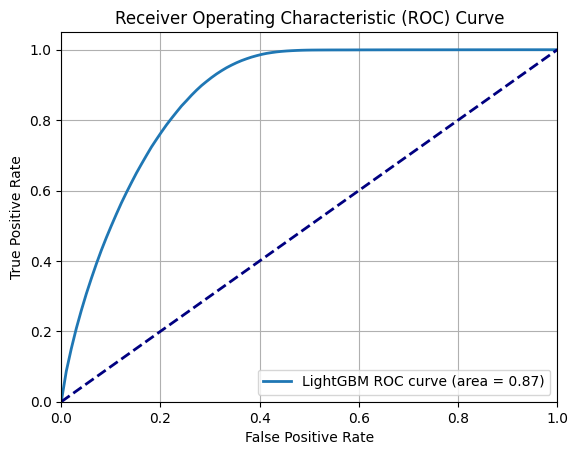

In [ ]:
plot_roc_curve(avg_fpr, avg_tpr, avg_roc_auc, "LightGBM")

In [ ]:
def plot_confusion_matrix(conf_matrix, model_name):
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix / np.sum(conf_matrix), annot=True, fmt='.2%', cmap='Blues', cbar=True, square=True)
    plt.title(f"{model_name} Confusion Matrix Heatmap")
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.xticks([0.5, 1.5], ['Predicted Negative', 'Predicted Positive'], rotation=0)
    plt.yticks([0.5, 1.5], ['Actual Negative', 'Actual Positive'], rotation=0)
    plt.show()

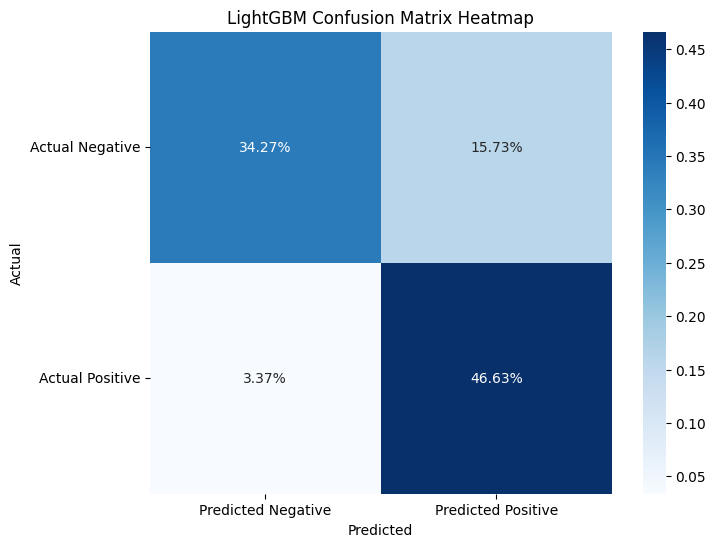

In [ ]:
plot_confusion_matrix(avg_metrics['conf_matrix'], "LightGBM")

In [ ]:
# Save the model
model_path = '/content/drive/My Drive/INSURANCE/lightgbm_model.pkl'
joblib.dump(lgb_model, model_path)

['/content/drive/My Drive/INSURANCE/lightgbm_model.pkl']